In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
data = pd.read_csv('PJME_hourly.csv', index_col=[0],
                            parse_dates=[0])

data.sort_index(inplace=True)

data.head(3)

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0


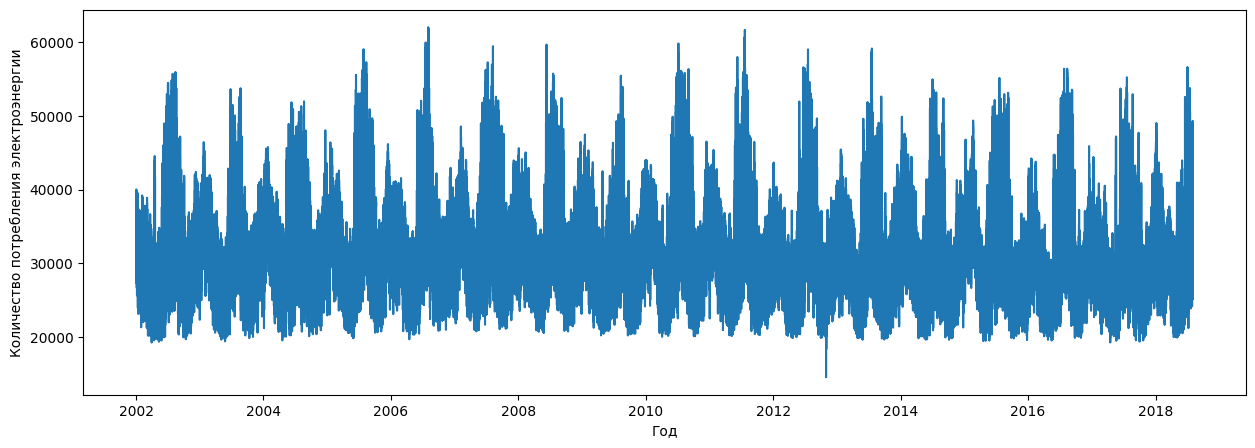

In [3]:
plt.figure(figsize=(15,5))
plt.xlabel('Год')
plt.ylabel('Количество потребления электроэнергии')
plt.plot(data["PJME_MW"])
plt.show()

In [4]:
# 80% данных на обучение
training_data_len = math.ceil(len(data) * .8)
training_data_len
 
# Сплит данных
train_data = data[:training_data_len].iloc[:,:1]
test_data = data[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(116293, 1) (29073, 1)


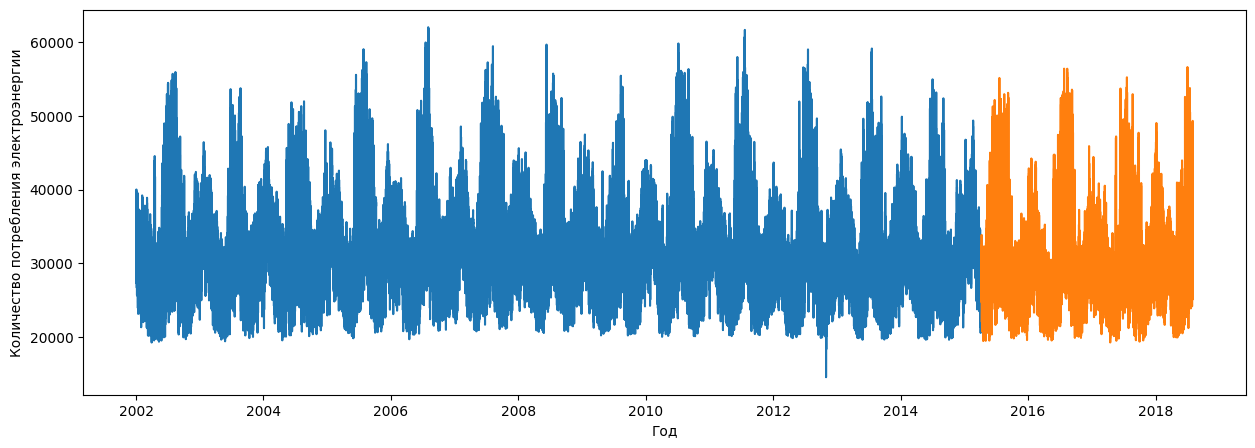

In [5]:
plt.figure(figsize=(15,5))
plt.xlabel('Год')
plt.ylabel('Количество потребления электроэнергии')
plt.plot(train_data)
plt.plot(test_data)
plt.show()

In [6]:
# Целевая переменная
dataset_train = train_data.PJME_MW.values
# Решейп в матрицу
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(116293, 1)

In [7]:
# Целевая переменная
dataset_test = test_data.PJME_MW.values
# Решейп в матрицу
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(29073, 1)

In [8]:
# Блок нормализации данных
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(dataset_train)
 
print(scaled_train[:5])

[[0.3339092 ]
 [0.31014432]
 [0.29101443]
 [0.28136522]
 [0.28469399]]


In [9]:
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[0.34250683] [0.34679017] [0.36012208] [0.3682872] [0.39053381]


In [10]:
# Создаем последовательность обучающих данных
sequence_length = 50  # Количество ретроспективных временных шагов
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Преобразование данных в тензоры
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([116243, 50, 1]), torch.Size([116243, 50, 1]))

In [11]:
# То же самое и для тестовых данных
sequence_length = 30
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([29043, 30, 1]), torch.Size([29043, 30, 1]))

In [12]:
# Определение архитектуры нейронной сети
class LSTMModel(nn.Module):
      # input_size : количество входных фичей
      # hidden_size : число LSTM юнитов Number of LSTM units 
      # num_layers : число LSTM слоев
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() # инициализация модели
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # прямой проход
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [13]:
# Убеждаемся, что видеокарта инициализирована
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
# Блок инициализации конфигурации и гиперпараметров модели (функция потерь - MSE, оптимизатор - Adam, скорость обучения - 1e-2)
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
 
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
 
loss_fn = torch.nn.MSELoss(reduction='mean')
 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [15]:
batch_size = 16
# Инициализация дата лоадеров для обучающего и тестового множества
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
num_epochs = 30
average_test_loss_min = np.Inf
train_hist =[]
test_hist =[]
# Цикл обучения
for epoch in range(num_epochs):
    train_loss = 0.0
 
    # Блок обучения
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        train_loss += loss.item()
 
    # Средняя ошибка обучения на обучающем
    average_loss = train_loss / len(train_loader)
    train_hist.append(average_loss)
 
    # Валидация модели
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            test_loss += test_loss.item()
 
        # Средняя ошибка обучения на тестовом множестве
        average_test_loss = test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    #if (epoch+1)%10==0:
        #print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        average_loss,
        average_test_loss
        ))
    # Сохраняем стейт модели на определенной эпохе, если ошибка валидационного множества снизилась
    if average_test_loss <= average_test_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        average_test_loss_min,
        average_test_loss))
        torch.save(model.state_dict(), 'model.pt')
        average_test_loss_min = average_test_loss

Epoch: 1 	Training Loss: 0.001176 	Validation Loss: 0.000005
Validation loss decreased (inf --> 0.000005).  Saving model ...
Epoch: 2 	Training Loss: 0.000570 	Validation Loss: 0.000002
Validation loss decreased (0.000005 --> 0.000002).  Saving model ...
Epoch: 3 	Training Loss: 0.000339 	Validation Loss: 0.000001
Validation loss decreased (0.000002 --> 0.000001).  Saving model ...
Epoch: 4 	Training Loss: 0.000240 	Validation Loss: 0.000001
Validation loss decreased (0.000001 --> 0.000001).  Saving model ...
Epoch: 5 	Training Loss: 0.000198 	Validation Loss: 0.000000
Validation loss decreased (0.000001 --> 0.000000).  Saving model ...
Epoch: 6 	Training Loss: 0.000176 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Epoch: 7 	Training Loss: 0.000164 	Validation Loss: 0.000000
Epoch: 8 	Training Loss: 0.000159 	Validation Loss: 0.000000
Epoch: 9 	Training Loss: 0.000155 	Validation Loss: 0.000000
Epoch: 10 	Training Loss: 0.000151 	Valida

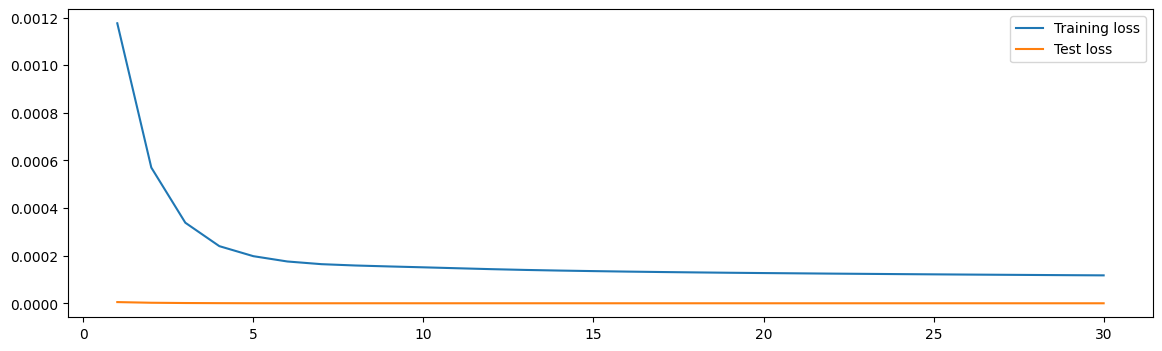

In [53]:
x = np.linspace(1,num_epochs,num_epochs)
train_hist_np = torch.tensor(train_hist, device = 'cpu')
test_hist_np = torch.tensor(test_hist, device = 'cpu')
plt.plot(x,train_hist, scalex=True, label="Training loss")
plt.plot(x,test_hist_np, label="Test loss")
plt.legend()
plt.show()

In [63]:
# Определяем количество будущих временных шагов для прогноза
num_forecast_steps = 30
 
# Конвертация в массив numpy
sequence_to_plot = X_test.squeeze().cpu().numpy()
 
# Последние 30 временных точек
historical_data = sequence_to_plot[-1]
print(historical_data.shape)
 
# Список для хранения спрогнозированных значений
forecasted_values = []
 
# Инициализация обученной модели
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Тензор с историческими данными
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Прогноз будущих данных
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
 
        # Добавления прогнозируемых значений в список
        forecasted_values.append(predicted_value[0])
 
        # Обновление исторических данных и добавление прогнозируемых данных
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value
 
         
# Генерация будущих дат
last_date = test_data.index[-1]
 
# Задаем генерацию 30 будущих дат
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
 
# Объединение исходного индекса с будущими датами
combined_index = test_data.index.append(future_dates)

(30,)


C:\Users\aw347\AppData\Local\Temp\ipykernel_17996\455815070.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


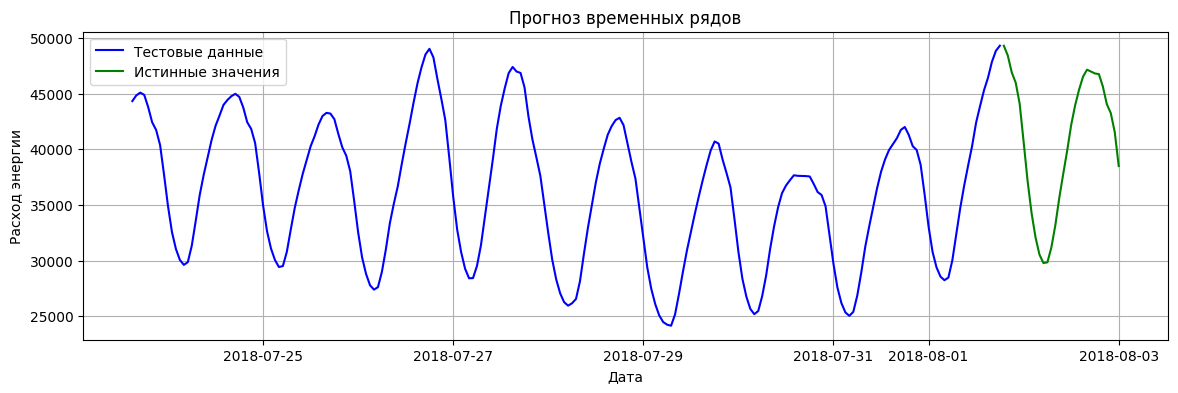

In [77]:
plt.rcParams['figure.figsize'] = [14, 4] 
 
 
#Тестовые данные
plt.plot(test_data.index[-250:-30], test_data.PJME_MW[-250:-30], label = "Тестовые данные", color = "b") 
#Отскалирование масштабированных данных
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 
 
#Исторические данные, подаваемые на вход
plt.plot(test_data.index[-30:], original_cases, label='Истинные значения', color='green') 

 
plt.xlabel('Дата')
plt.ylabel('Расход энергии')
plt.legend()
plt.title('Прогноз временных рядов')
plt.grid(True)

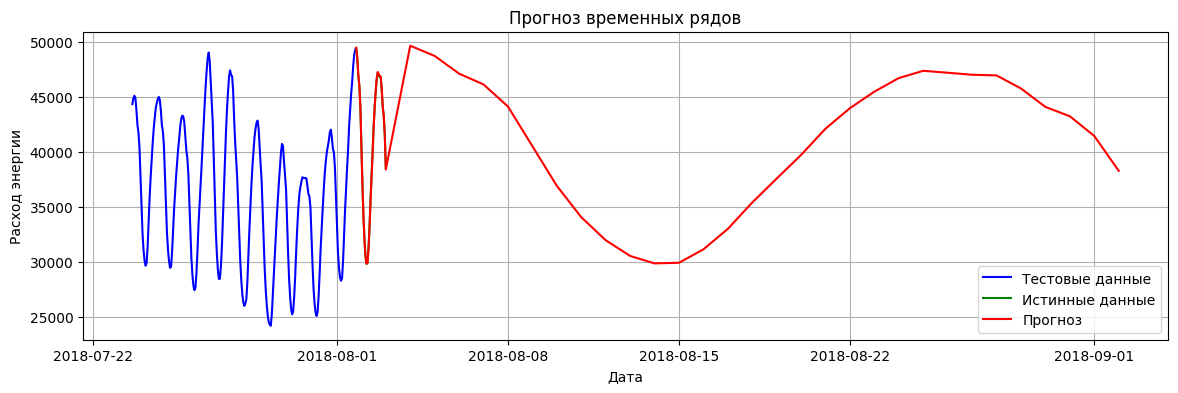

In [78]:
plt.rcParams['figure.figsize'] = [14, 4] 
 
 
# Тестовые данные
plt.plot(test_data.index[-250:-30], test_data.PJME_MW[-250:-30], label = "Тестовые данные", color = "b") 
# Отскалирование масштабированных данных
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 
 
# Исторические данные, подаваемые на вход
plt.plot(test_data.index[-30:], original_cases, label='Истинные данные', color='green') 
 
# Исторические данные, подаваемые на вход
# Отскалирование прогнозируемых данных
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# Вывод спрогнозированных данных
plt.plot(combined_index[-60:], forecasted_cases, label='Прогноз', color='red')  
 
plt.xlabel('Дата')
plt.ylabel('Расход энергии')
plt.legend()
plt.title('Прогноз временных рядов')
plt.grid(True)